# Sowing Success: How Machine Learning Helps Farmers Select the Best Crops

![Farmer in a field](farmer_in_a_field.jpg)

Measuring essential soil metrics such as nitrogen, phosphorous, potassium levels, and pH value is an important aspect of assessing soil condition. However, it can be an expensive and time-consuming process, which can cause farmers to prioritize which metrics to measure based on their budget constraints.

Farmers have various options when it comes to deciding which crop to plant each season. Their primary objective is to maximize the yield of their crops, taking into account different factors. One crucial factor that affects crop growth is the condition of the soil in the field, which can be assessed by measuring basic elements such as nitrogen and potassium levels. Each crop has an ideal soil condition that ensures optimal growth and maximum yield.

A farmer reached out to you as a machine learning expert for assistance in selecting the best crop for his field. They've provided you with a dataset called `soil_measures.csv`, which contains:

- `"N"`: Nitrogen content ratio in the soil
- `"P"`: Phosphorous content ratio in the soil
- `"K"`: Potassium content ratio in the soil
- `"ph"` value of the soil
- `"crop"`: categorical values that contain various crops (target variable).

Each row in this dataset represents various measures of the soil in a particular field. Based on these measurements, the crop specified in the `"crop"` column is the optimal choice for that field.  

In this project, you will build multi-class classification models to predict the type of `"crop"` and identify the single most importance feature for predictive performance.

In [1]:
# All required libraries are imported here for you.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load dataset
df = pd.read_csv('soil_measures.csv')

Original dataset size: 2200
Cleaned dataset size: 1937
Number of rows removed: 263


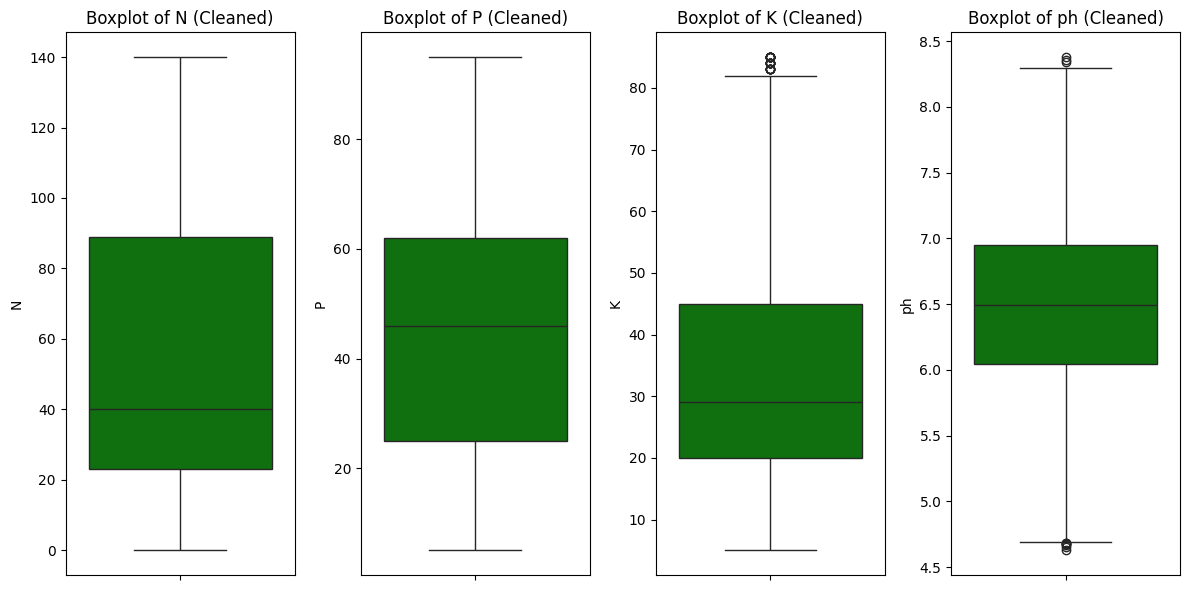

In [3]:
# Define numerical features to check for outliers
numerical_features = ['P', 'K']

# Function to remove outliers using IQR
def remove_outliers_iqr(data, columns):
    df_cleaned = data.copy()
    for col in columns:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
    return df_cleaned

# Remove outliers from all numerical features
df_cleaned = remove_outliers_iqr(df, numerical_features)

# Print the number of rows removed
print(f"Original dataset size: {df.shape[0]}")
print(f"Cleaned dataset size: {df_cleaned.shape[0]}")
print(f"Number of rows removed: {df.shape[0] - df_cleaned.shape[0]}")

# Plot boxplots for cleaned data
plt.figure(figsize=(12, 6))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, len(numerical_features), i)
    sns.boxplot(y=df_cleaned[feature], color='green')
    plt.title(f'Boxplot of {feature} (Cleaned)')
plt.tight_layout()
plt.show()

In [4]:
# Feature and target selection
X = df_cleaned[['N', 'P', 'K', 'ph']]
y = df_cleaned['crop']

In [5]:
# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Preprocessing: Standardize numerical features
numerical_features = ['N', 'P', 'K', 'ph']
X[numerical_features] = X[numerical_features].astype('float64')
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numerical_features] = scaler.fit_transform(X[numerical_features])

# print(X_scaled.dtypes)
# print(X_scaled.head())

C:\Users\tungv\AppData\Local\Temp\ipykernel_33744\3767542129.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_features] = X[numerical_features].astype('float64')


In [6]:
# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

In [7]:
# Define parameter grids for XGBoost and LightGBM
xgb_params = {
    'max_depth': [10, 20],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'subsample': [0.7, 0.9]
}

# lgb_params = {
#     'max_depth': [10, 20],  # Allow unlimited depth
#     'num_leaves': [31],  # Control tree complexity
#     'min_gain_to_split': [0.01],  # Set a small positive value to allow splits
#     'min_data_in_leaf': [10],  # Ensure leaves contain enough samples
#     'subsample': [0.7, 0.9],  # Use 80% of data per boosting round
#     'colsample_bytree': [0.8],  # Use 80% of features
#     'learning_rate': [0.1, 0.3],
#     'n_estimators': [100, 200]
# }


In [8]:
# Perform hyperparameter tuning using cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# XGBoost tuning
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss',verbosity=1)
xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=xgb_params, cv=kf, scoring='accuracy', n_jobs=1, verbose=1)
xgb_grid.fit(X_train, y_train)

# # LightGBM tuning
# lgb_model = lgb.LGBMClassifier(class_weight='balanced')
# lgb_grid = GridSearchCV(estimator=lgb_model, param_grid=lgb_params, cv=kf, scoring='accuracy', n_jobs=1, verbose=1)
# lgb_grid.fit(X_train, y_train)



Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importan...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [10, 20], 'n_estimators': [100, 200],
                         'subsample': [0.7, 0.9]},
             scoring='accuracy', verbose=1)

In [9]:
# Evaluate models
xgb_best_model = xgb_grid.best_estimator_
xgb_pred = xgb_best_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)

# lgb_best_model = lgb_grid.best_estimator_
# lgb_pred = lgb_best_model.predict(X_test)
# lgb_accuracy = accuracy_score(y_test, lgb_pred)

print(f'XGBoost Accuracy: {xgb_accuracy:.4f}')
print(f"Best parameters for XGBoost: {xgb_grid.best_params_}")
print(f"Classification Report:\n{classification_report(y_test, xgb_pred)}")

# print(f'LightGBM Accuracy: {lgb_accuracy:.4f}')
# print(f"Best parameters for LightGBM: {lgb_grid.best_params_}")
# print(f"Classification Report:\n{classification_report(y_test, lgb_pred)}")

XGBoost Accuracy: 0.8119
Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.7}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.68      0.85      0.76        20
           2       1.00      1.00      1.00        18
           3       0.81      0.85      0.83        20
           4       1.00      0.95      0.97        20
           5       0.95      1.00      0.98        20
           6       0.61      0.55      0.58        20
           7       0.71      1.00      0.83        20
           8       0.60      0.60      0.60        20
           9       1.00      1.00      1.00        20
          10       0.82      0.74      0.78        19
          11       1.00      0.67      0.80        12
          12       0.76      0.95      0.84        20
          13       0.57      0.60      0.59        20
          14       1.00      1.0

<Figure size 1000x600 with 0 Axes>

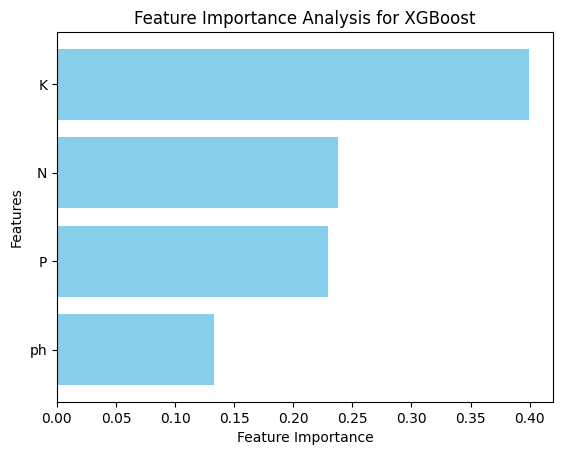

In [10]:

# Get feature importance from the XGBoost model
feature_importance = xgb_best_model.feature_importances_
feature_names = X_train.columns

# Create a sorted index for the features by importance
sorted_idx = np.argsort(feature_importance)[::-1]

# Sort feature names and importance values for plotting
sorted_feature_names = feature_names[sorted_idx]
sorted_feature_importance = feature_importance[sorted_idx]

# Plot the feature importance as a bar chart
plt.figure(figsize=(10, 6))
plt.figure()
plt.barh(sorted_feature_names, sorted_feature_importance, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Analysis for XGBoost')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features on top
plt.show()